$$\require{mhchem}$$       

# Problem 1: Multiple reactions in batch tank

Consider the following two irreversible elementary reactions:
\begin{align}
2A&\rightarrow 2B+2C && k_1\\
B&\rightarrow D && k_2
\end{align}
in which $k_1 = 0.05$ L/mol$\cdot$min and $k_2=0.022$/min.  The reactor volume is 100 L and the initial concentration of A is 1.5 mol/L.

#### Part 1A:  Write down the rate equation for each for the reactions (1 pt)

$r_1=k_1 C_A^2$, $r_2=k_2 C_B$

#### Part 1B:  Plot the concentration of each species over the first three hours (3 pt)

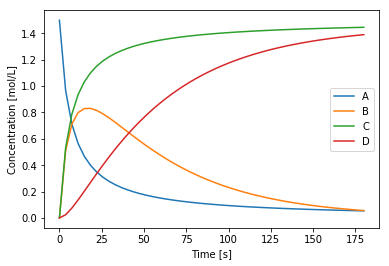

In [13]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

k1 = 0.05   # L/mol/min
k2 = 0.022  # L/min

C0 = [1.5, 0, 0, 0]  # mol/L of A, B, C, & D, respectively

def dCdt(C, t):
    '''
    Calculate a list of reaction rates for each species
    Inputs:
        C   A list of concentration values where the first index corresponds to A,
            the second index corresponds to B, etc., in units of mol/L
        t   A float of the time that we want to look at the system, in units of min
    Output:
        dcdt    A list of reaction rates for A, B, C, & D, respectively. Units of mol/L/min
    and time `t`.
    '''
    r1 = k1*C[0]**2
    r2 = k2*C[1]
    dcdt = [-2*r1, 2*r1-r2, 2*r1, r2]
    return dcdt

# Define the time to integrate/plot over, and then use `odeint` to integrate.
trange = np.linspace(0, 180)
soln = odeint(dCdt, C0, trange)

# Plot
plt.plot(trange, soln)
plt.xlabel('Time [s]')
plt.ylabel('Concentration [mol/L]')
plt.legend(['A', 'B', 'C', 'D'])
plt.show()

#### Part 1C:  At what time should we stop the reaction to maximize the concentration of the valuable intermediate B? Calculate this value numerically, i.e., don't simply use the plot you made in Problem 1B). (3 pt)

In [14]:
# We want to maximize the concentration of B (Cb), but scipy.optimize only has a `minimize`
# function. We address this by minimizing -Cb, which is equivalent to maximizing Cb.
from scipy.optimize import minimize

# Re-define C0 in case some other cell in this notebook defined it otherwise
C0 = [1.5, 0, 0, 0]  # mol/L of A, B, C, & D, respectively

def neg_Cb(stop_time):
    '''
    Calculate the negative of the concentration of B as a function of time
    Input:
        stop_time   The time at which we want to stop the reaction
    Output:
        -Cb  The negative of the concentration of B at time `stop_time`
    '''
    # Integrate concentrations over time
    trange = np.linspace(0, stop_time)
    C = odeint(dCdt, C0, trange)
    # Pull out the concentration vector at time `stop_time`
    Cf = C[-1]
    # Pull out the concentration of B
    Cb = Cf[1]
    return -Cb

soln = minimize(neg_Cb, 20)
print('Time of max Cb = {:1.3f} s'.format(soln['x'][0]))
maxCb = soln['fun']

Time of max Cb = 16.692 s


#### Part 1D:  The operator suggests that we perform the reaction in 2 stages. For Stage 1, start with only half of A (that is, start with 75 mol of A in the 100 L reactor). When we notice a maximum in $C_B$, begin Stage 2 by dumping the remaining 75 moles of A into the reactor and wait again until we see a maximum in $C_B$. Assume that the addition of 75 moles of A does not change the volume of the batch.
First:  Find the time at which we should end Stage 1. Second:  Plot all four species concentrations as a function of time for both Stage 1 and Stage 2. Is the maximum concentation of B in Stage 2 higher or lower than it was in Part 1B? (3 pt)

Stage 1 ends at 23.078 s


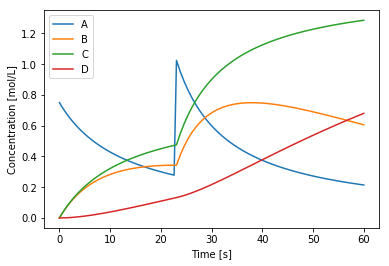

Stage 2 ends at 37.949 s
Final Cb of first case = 0.833 M
Final Cb of second case = 0.749 M


In [15]:
# The function we defined, `neg_Cb`, relies on the value of `C0`. If `C0` changes,
# then the output of `neg_Cb` will change with it. Therefore, we only need to redefine `C0`
# to be able to use `neg_Cb` again for this problem.
C0 = [0.75, 0, 0, 0] # mol/L

# Do Part 1C again, but with the new `C0`. This will give us `t1`, the time at
# which Stage 1 ends and Stage 2 begins.
soln1 = minimize(neg_Cb, 25)
t1 = soln1['x'][0]
print('Stage 1 ends at {:1.3f} s'.format(t1))

# Integrate the species concentrations through Stage 1 to find the species
# concentrations at the end of stage 1/beginning of stage 2, `Cf1`
trange1 = np.linspace(0, t1)
C1 = odeint(dCdt, C0, trange1)
Cf1 = C1[-1, :]

# Add the remaining A and then integrate species concentrations through Stage 2.
trange2 = np.linspace(t1, 60)
Cf1[0] += 0.75
C2 = odeint(dCdt, Cf1, trange2)

# Plot
plt.plot(np.append(trange1, trange2), np.append(C1, C2, axis=0))
plt.xlabel('Time [s]')
plt.ylabel('Concentration [mol/L]')
plt.legend(['A', 'B', 'C', 'D'])
plt.show()

# Re-define the `neg_Cb` function since we have new integration limits
def neg_Cb(t2):
    trange2 = np.linspace(t1, t2)
    C2 = odeint(dCdt, Cf1, trange2)
    Cb = C2[-1, 1]
    return -Cb
# Re-do Part 1C again, but for Stage 2 instead of Stage 1
soln2 = minimize(neg_Cb, 38)
t2 = soln2['x'][0]

print('Stage 2 ends at {:1.3f} s'.format(t2))
print('Final Cb of first case = {:1.3f} M'.format(-maxCb))
print('Final Cb of second case = {:1.3f} M'.format(-soln2['fun']))

# Problem 2: 

The pyrolysis of benzene can be described with two reactions.  Diphenyl is produced by the dehydrogenation of benzene,

$\ce{2C6H6 <=>[k_1][k_{-1}] C12H10 + H2}$

Triphenyl is formed by the secondary reaction,

$\ce{C6H6 + C12H10 <=>[k_2][k_{-2}] C18H14 + H2}$

with the rate constants
\begin{align*}
k_1 = 7 \times 10^5 L/mol\cdot hr && K_1=0.31\\
k_2 = 4 \times 10^5 L/mol\cdot hr && K_2=0.48\\
\end{align*}

and $K$ is the equilibrium coefficient (for example, $K=k_1/k_{-1}$).

#### Part 2A:  Assuming the reactions are assumed to be elementary, write down the rate expression for each reaction, with $C_B,C_D,C_T,C_H$ referring to the concentrations of benzene, diphenyl, triphenyl, and hydrogen respectively (1 pt)

$r_1=k_1C_B^2-k_{-1}C_DC_H$

$r_2=k_2C_BC_D-k_{-2}C_TC_H$

#### Part 2B:  The reaction will be carried out in an isothermal PFR, with an inlet gas feed of 60 kmol/hr of pure benzene at 1033 K and 1.0 atm.  Calculate the volumetric flow rate of benzene.  Will the volumetric flow rate change along the length of the reactor? (1 pt)

In [16]:
R = 0.08206   # L atm / mol K
T = 1033      # K
P = 1.0       # atm
N_Bf = 60000. # mol/hr
Q = R*T/P*N_Bf
print('Flow rate is {} L/hr'.format(Q))

Flow rate is 5086078.8 L/hr


The flow rate will not change because both reactions have no net change in moles of gas.

#### Part 2C:  Using a mole balance for each species, solve for and plot the mole fraction of each species as a function of the volume of the reactor, up to 1500 L. (3pt)

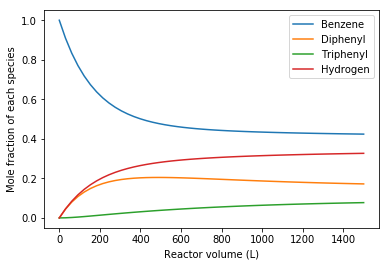

In [17]:
# Rate and equilibrium constants
k1 = 7*10**5 # L/mol/hr
k2 = 4*10**5 # L/mol/hr
K1 = 0.31
K2 = 0.48
k1r = k1/K1
k2r = k2/K2

# Molar flowrates (mol/hr)
F0 = [60000, 0, 0, 0]   # CB, CD, CT, CH

def dFdV(F, V):
    '''
    Calculate the change in molar flowrates as the feed passes through a particular
    volume of PFR.
    
    Inputs:
        F   A list of the molar flowrates (mol/hr) of benzene, diphenyl, triphenyl,
            and hydrogen, respectively, after the feed has passed through `V` liters
            of the PFR
        V   The volume of the PFR that the feed has passed through so far
    Output:
        dfdv    A list of the change in molar flowrates after the feed has passed
                through `V` liters. This is analogous to the CSTR's concentration/time
                gradient, but for a PFR instead.
    '''
    r1 = k1*F[0]**2/Q**2 - k1r*F[1]*F[3]/Q**2
    r2 = k2*F[0]*F[1]/Q**2 - k2r*F[2]*F[3]/Q**2
    dfdv = [-2*r1-r2, r1-r2, r2, r1+r2]
    return dfdv

# Integrate dFdV
Vrange = np.linspace(0, 1500)
soln = odeint(dFdV, F0, Vrange)

# Plot
plt.plot(Vrange, soln/60000)
plt.xlabel('Reactor volume (L)')
plt.ylabel('Mole fraction of each species')
plt.legend(labels=['Benzene', 'Diphenyl', 'Triphenyl', 'Hydrogen'])
plt.show()

#### Part 2D:  Identify the volume at which the reactor achieves 50% conversion of benzene, using the odelay (see Section 5.5.3 from [this](http://kitchingroup.cheme.cmu.edu/pycse/pycse.html) page) function to stop integration at that point (3pt)

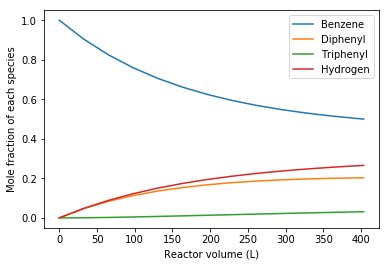

Final volume: 403.3476089069265 L


In [18]:
from pycse import odelay

# Define the `event` function that odelay needs to know 
def event(N, V):
    value = N[0]/60000-0.5
    isterminal = True
    direction = 0
    return value, isterminal, direction

# Execute integration
Vrange = np.linspace(0, 1600)
V, N, Ve, Ne, ie = odelay(dFdV, F0, Vrange, [event])

# Plot
plt.plot(V, N/60000)
plt.xlabel('Reactor volume (L)')
plt.ylabel('Mole fraction of each species')
plt.legend(labels=['Benzene', 'Diphenyl', 'Triphenyl', 'Hydrogen'])
plt.show()

print('Final volume: {} L'.format(V[-1]))

#### Part 2E:  This problem could also be solved using differential equations for the extent of each of the reactions $X_1, X_2$.  Solve for these two extents as a function of the reactor volume, and plot them over the same range (up to 50% benzene conversion). In this case,
\begin{align}
N_j = N_{jf} + \sum_i^{N_rxn} v_{ij}X_i
\end{align}
#### where $v_{ij}$ is the stoichiometric coefficient coefficient of $j$th species in the $i$th reaction. To save time, you may use this code template: (2pt)

~~~
stoich_coefficients = # Fill this in!
k1 = # Fill this in!
k1r = # Fill this in!
k2 = # Fill this in!
k2r = # Fill this in!
Q = # Fill this in!
F0 = # Fill this in!
xi0 = # Fill this in!

def dxidV(xi, V):
    F = F0 + np.matmul(stoich_coefficients.transpose(), xi)
    r1 = k1*F[0]**2/Q**2 - k1r*F[1]*F[2]/Q**2
    r2 = k2*F[0]*F[1]/Q**2 - k2r*F[2]*F[3]/Q**2
    return [r1, r2]

def event(xi, V):
    value = # fill this in!
    isterminal = True
    direction = 0
    return value, isterminal, direction

Vrange = np.linspace(0, 1500)
V, xi, Ve, xie, ie = odelay(dxidV, xi0, Vrange, [event])

plt.plot(V, xi/30000)
plt.xlabel('Reactor volume (L)')
plt.ylabel('Mole fraction of each species')
plt.legend(labels=['$xi_1$','$xi_2$'])
plt.show()
print('The volume required for 50% conversion is {} L'.format(Ve[0]))
~~~

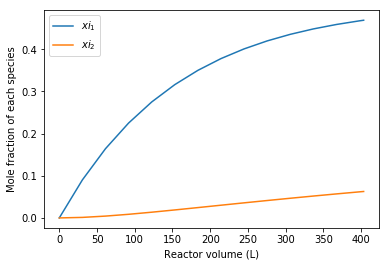

The volume required for 50% conversion is 403.3476384488377 L


In [19]:
stoich_coefficients = np.array([[-2,1,1,0],[-1,-1,1,1]])
xi0 = np.array([0, 0])

def dxidV(xi, V):
    F = F0 + np.matmul(stoich_coefficients.transpose(), xi)
    r1 = k1*F[0]**2/Q**2 - k1r*F[1]*F[2]/Q**2
    r2 = k2*F[0]*F[1]/Q**2 - k2r*F[2]*F[3]/Q**2
    return [r1, r2]

def event(xi,V):
    value = -np.dot(stoich_coefficients[:,0],xi)/60000-0.5
    isterminal = True
    direction = 0
    return value, isterminal, direction

Vrange = np.linspace(0, 1500)
V, xi, Ve, xie, ie = odelay(dxidV, xi0, Vrange, [event])

plt.plot(V, xi/30000)
plt.xlabel('Reactor volume (L)')
plt.ylabel('Mole fraction of each species')
plt.legend(labels=['$xi_1$','$xi_2$'])
plt.show()
print('The volume required for 50% conversion is {} L'.format(Ve[0]))